In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
def plot_predictions(train_data,
                     train_labels,
                     test_data,
                     test_labels,
                     predictions=None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data ub green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
    # Show the legend
    plt.legend(prop={"size": 14});

In [4]:
weight, bias = 0.3, 0.9

start = 0
end = 1
step = 0.001

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

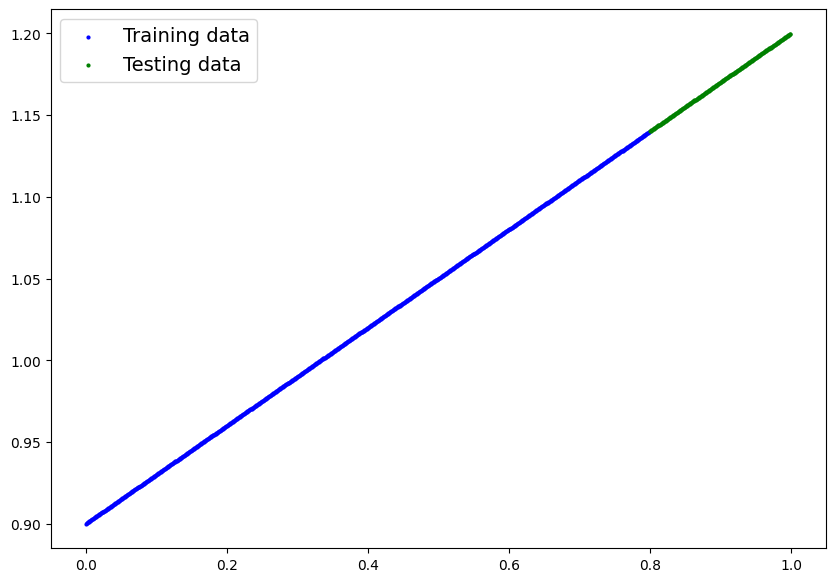

In [5]:
plot_predictions(X_train, y_train, X_test, y_test)

In [6]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(1, dtype=torch.float),requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.weight * x + self.bias
    
torch.manual_seed(1234)
model = LinearRegressionModel().to(device)
model, model.state_dict(), next(model.parameters()).device

(LinearRegressionModel(),
 OrderedDict([('weight', tensor([0.0461], device='cuda:0')),
              ('bias', tensor([0.4024], device='cuda:0'))]),
 device(type='cuda', index=0))

In [7]:
# Create a loss function
loss_fn = nn.L1Loss()

# Create a optimizer
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [8]:
torch.manual_seed(1234)

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

epochs = 300

for epoch in range(epochs):
    ### Training
    model.train()

    # 1. Forward pass
    y_pred = model(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step optimizer
    optimizer.step()

    ### validation
    model.eval()

    # inference mode
    with torch.inference_mode():
        # Forward pass
        test_preds = model(X_test)
        # Calculate the loss
        test_loss = loss_fn(test_preds, y_test)

    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

Epoch 0: Train Loss: 0.5990, Test Loss: 0.7124
Epoch 20: Train Loss: 0.3671, Test Loss: 0.4405
Epoch 40: Train Loss: 0.1352, Test Loss: 0.1686
Epoch 60: Train Loss: 0.0064, Test Loss: 0.0141
Epoch 80: Train Loss: 0.0080, Test Loss: 0.0059
Epoch 100: Train Loss: 0.0080, Test Loss: 0.0059
Epoch 120: Train Loss: 0.0080, Test Loss: 0.0059
Epoch 140: Train Loss: 0.0080, Test Loss: 0.0059
Epoch 160: Train Loss: 0.0080, Test Loss: 0.0059
Epoch 180: Train Loss: 0.0080, Test Loss: 0.0059
Epoch 200: Train Loss: 0.0080, Test Loss: 0.0059
Epoch 220: Train Loss: 0.0080, Test Loss: 0.0059
Epoch 240: Train Loss: 0.0080, Test Loss: 0.0059
Epoch 260: Train Loss: 0.0080, Test Loss: 0.0059
Epoch 280: Train Loss: 0.0080, Test Loss: 0.0059


In [9]:
# Find our model's parameters
from pprint import pprint as pp # # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html 
print("The model learned the following values for weights and bias:")
pp(model.state_dict())
print("\nAnd the original values for weights and bias are:")
pp(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weight', tensor([0.2996], device='cuda:0')),
             ('bias', tensor([0.9081], device='cuda:0'))])

And the original values for weights and bias are:
'weights: 0.3, bias: 0.9'


In [10]:
model.eval()

with torch.inference_mode():
    y_preds = model(X_test)

y_preds[:10]

tensor([[1.1478],
        [1.1481],
        [1.1484],
        [1.1487],
        [1.1490],
        [1.1493],
        [1.1496],
        [1.1499],
        [1.1502],
        [1.1505]], device='cuda:0')

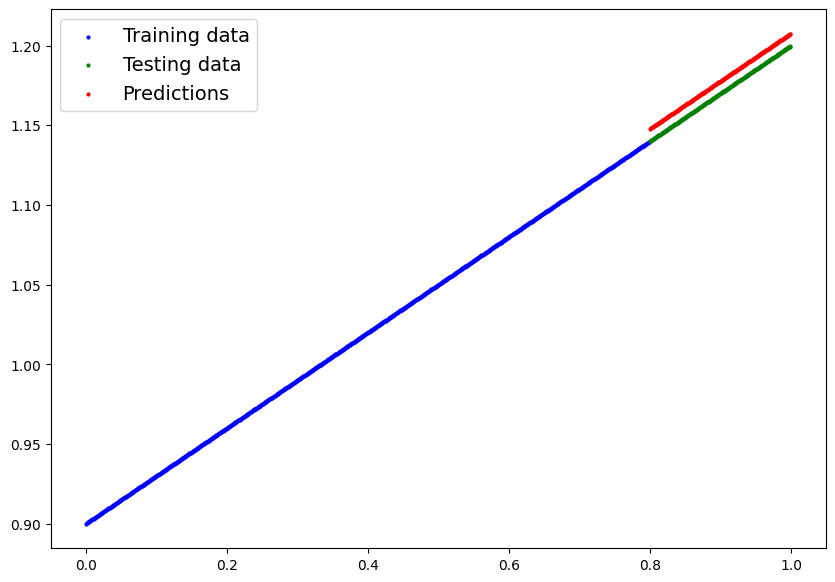

In [11]:
plot_predictions(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), predictions=y_preds.cpu())

In [12]:
from pathlib import Path

# Save the trained model's state_dict() to file 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_exercise.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model's state_dict
print(f"Saving model state_dict to: {MODEL_SAVE_PATH}")
torch.save(model.state_dict(), f=MODEL_SAVE_PATH)

Saving model state_dict to: models/01_exercise.pth


In [13]:
# Create a new instance
model_val = LinearRegressionModel()

model_val.load_state_dict(torch.load(MODEL_SAVE_PATH))

model_val.to(device)

print(f"Load model:\n {model_val}")
print(f"Model device: \n {next(model_val.parameters()).to(device)}")

Load model:
 LinearRegressionModel()
Model device: 
 Parameter containing:
tensor([0.2996], device='cuda:0', requires_grad=True)


In [15]:
# vs
model_val.eval()

with torch.inference_mode():
    loaded_preds = model_val(X_test)

y_preds[:10] == loaded_preds[:10]

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')